# Deep Learning &mdash; Assignment 11

Assignment for week 11 of the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:**
Daan Brugmans, Maximilian Pohl

**Group:**
31

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a diffusion model
2. Extend the model to a class-conditional version

## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [1]:
%config InlineBackend.figure_formats =['png']
%matplotlib inline

from d2l import torch as d2l
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

## 11.1 MNIST dataset

In this assignment we will once again use the MNIST digit dataset. This dataset consists of 28×28 binary images and has 60000 training examples divided over 10 classes. We split this into 55000 images for training and 5000 images for validation.

As preprocessing, we pad the images to 32x32 pixels and scale the intensities to [-1, +1].

**(a) Run the code below to load the MNIST dataset.**

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2),  # pad to 32x32 pixels
    transforms.Normalize(0.5, 0.5),  # normalize to [-1, +1]
])
train_val_data = datasets.MNIST('data', train=True, download=True, transform=transform)
# Split into train and validation set
train_data, validation_data = torch.utils.data.random_split(train_val_data, [55000, 5000])
# Create data loaders
train_iter = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
validation_iter = torch.utils.data.DataLoader(validation_data, batch_size=1000)
num_classes = 10

## 11.2 Training images (4 points)

We will implement a model from the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf) by Ho et al., 2020.

We reuse some parameter settings from the paper:

In [21]:
device = d2l.try_gpu()
diffusion_steps = 1000
beta = torch.linspace(1e-4, 0.02, diffusion_steps).to(device)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

Using these settings, we can generate a sequence of noisy images with
\begin{aligned}
\mathbf{x}_t 
&= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} & \text{ where } \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I}).
\end{aligned}

There is a closed-form solution to compute $x_t$ directly from $x_0$ (see the paper or [this blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#forward-diffusion-process)):
\begin{aligned}
\mathbf{x}_t &= \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} & \text{ where } \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}).
\end{aligned}

**(a) Implement this closed-form solution in the code below to generate random images.<span style="float:right"> (1 point)</span>**

*Expected output: you should see some images with recognizable shapes and some images with noise.*

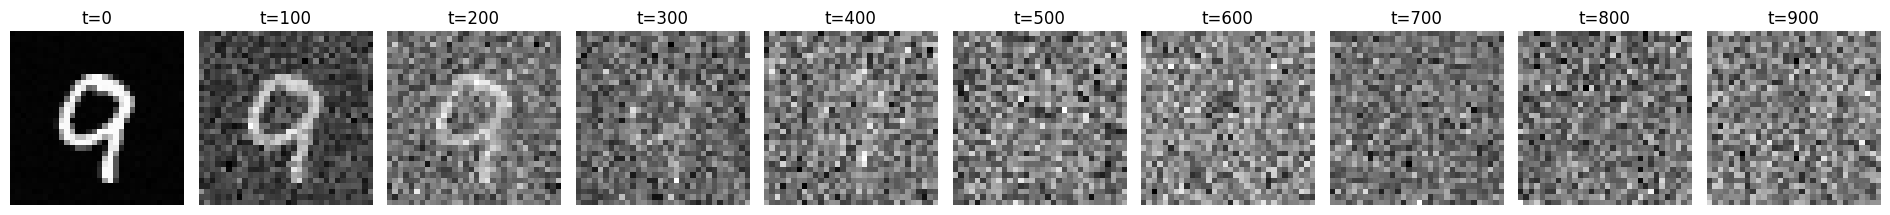

In [12]:
# sample some original images
x_0, y = next(iter(train_iter))

plt.figure(figsize=(19, 21))
for i, t in enumerate(range(0, diffusion_steps, 100)):
    # TODO generate random noise
    noise = torch.normal(0, 1, x_0.shape)

    # TODO add noise to the original image to compute x_t
    x_t = torch.sqrt(alpha_bar[t]) * x_0 + torch.sqrt(1 - alpha_bar[t]) * noise

    plt.subplot(3, diffusion_steps // 100, i + 1)
    plt.imshow(x_t[0, 0], cmap='gray')
    plt.axis('off')
    plt.title(f't={t}')
plt.tight_layout()

**(b) Describe how we should interpret these images, and how they can be used to train the diffusion model.<span style="float:right"> (2 points)</span>**

In the beginning, we saw the clear sample from the input images without any noise. Along the line, we add more and more noise, which makes the image less clear in every step.
We can use this to train a network reversing this process by predicting some shape out of noise every step in reverse. As we generated "real" noisy samples, we can use them to compare them with the network. 

During training, we will need a minibatch with multiple images and multiple time steps.

**(c) Complete the function below to add noise to a minibatch of images.<span style="float:right"> (1 point)</span>**

In [8]:
def generate_noisy_samples(x_0, beta):
    '''
    Create noisy samples for the minibatch x_0.
    Return the noisy image, the noise, and the time for each sample.
    '''
    alpha = 1.0 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    alpha_bar = alpha_bar.to(x_0.device)

    # sample a random time t for each sample in the minibatch
    t = torch.randint(beta.shape[0], size=(x_0.shape[0],), device=x_0.device)
    # TODO generate noise
    noise = torch.normal(0, 1, x_0.shape, device=x_0.device)
    # TODO add the noise to each sample
    x_t = torch.sqrt(alpha_bar[t]).reshape(x_0.shape[0], 1, 1, 1) * x_0 + torch.sqrt(1 - alpha_bar[t]).reshape(
        x_0.shape[0], 1, 1, 1) * noise
    return x_t, noise, t

**(d) Try out your new function by generating a few noisy samples.**

*Expected output: you should see the samples in the minibatch with different levels of noise, depending on the time $t$ for each sample.*

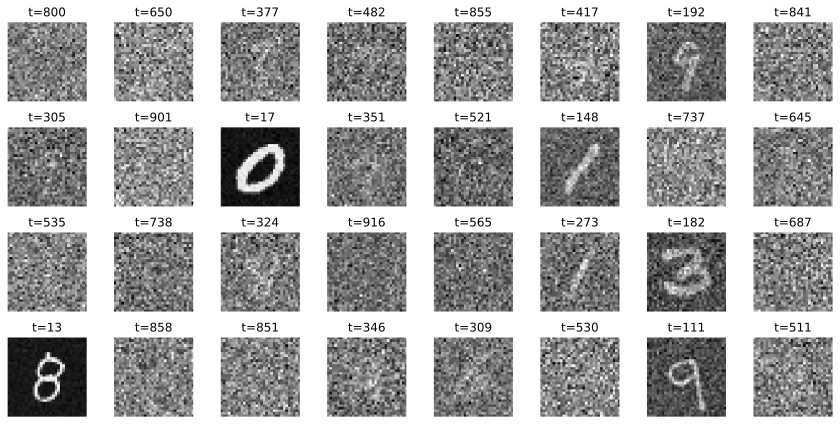

In [14]:
x_0, y = next(iter(train_iter))

x_t, noise, sampled_t = generate_noisy_samples(x_0, beta)
assert x_t.shape == x_0.shape
assert noise.shape == x_0.shape
assert sampled_t.shape == (x_0.shape[0],)

plt.figure(figsize=(12, 6))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(x_t[i, 0], cmap='gray')
    plt.axis('off')
    plt.title(f't={sampled_t[i]}')
plt.tight_layout()

## 11.3 Helper functions

We will use some predefined components to construct our model, based on [an existing implementation](https://github.com/dome272/Diffusion-Models-pytorch) on GitHub.

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, h_size):
        super(SelfAttention, self).__init__()
        self.h_size = h_size
        self.mha = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )

    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value


class SAWrapper(nn.Module):
    def __init__(self, h_size, num_s):
        super(SAWrapper, self).__init__()
        self.sa = nn.Sequential(*[SelfAttention(h_size) for _ in range(1)])
        self.num_s = num_s
        self.h_size = h_size

    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s * self.num_s).swapaxes(1, 2)
        x = self.sa(x)
        x = x.swapaxes(2, 1).view(-1, self.h_size, self.num_s, self.num_s)
        return x


# U-Net code adapted from: https://github.com/milesial/Pytorch-UNet

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, in_channels, residual=True)
            self.conv2 = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## 11.4 Diffusion model (5 points)

Similar to Ho et al. and to several online implementations, we will use a U-Net with self-attention and positional embedding as our diffusion model.

**(a) Familiarize yourself with the architecture of this U-Net.**

In [5]:
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, device="cuda"):
        super().__init__()
        self.device = device

        bilinear = True
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, c_out)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
                10000
                ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32)
        output = self.outc(x)
        return output

**(b) What does the positional encoding encode? Why would this be useful?<span style="float:right"> (2 points)</span>**

The positional encoding encodes the step t, i.e., the order of the images when we noised or denoised the image.

Since the U-Net is an attention network, it does not look at the order of inputs, unless we encode the order into the inputs using positional encoding. This allows the self-attention network to understand at what time step the image is, possibly learning a sense of amount of noise added. Using the positional encoding, the network can put more attention to the more recent steps it took, such that it has a clear direction of decoding.

**(c) Describe how this model will be used. What do the inputs and outputs represent?<span style="float:right"> (3 points)</span>**

*Used for:* Denoising the image given for one step

*Inputs:* Image with noise added for step t

*Outputs:* Noise detected in the image of step t

## 11.5 Training the model (7 points)

We will train our diffusion model using Algorithm 1 from the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf) by Ho et al., 2020.

**(a) The algorithm uses $\mathbf{x}_0$. How do you obtain $\mathbf{x}_0$ during training?<span style="float:right"> (1 point)</span>**

We sample it from the dataset

**(b) Which two values are compared in the loss on line 5 of the algorithm?<span style="float:right"> (1 point)</span>**

We compare the generated image of step t with the final target, i.e., the original image in step 0.

**(c) Implement this procedure in the training loop below.<span style="float:right"> (3 points)</span>**

In [6]:
loss_fn = torch.nn.MSELoss()


def train(model: UNet, beta, num_epochs=10, lr=1e-3):
    """Train a diffusion model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                            legend=['train loss', 'validation loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        model.train()
        for x, y in train_iter:
            x = x.to(device)
            optimizer.zero_grad()

            # TODO compute the loss for minibatch x
            # hint: we already have a function to generate noisy images
            noisy_samples, noise, t = generate_noisy_samples(x, beta)
            y = model.forward(noisy_samples, t)
            loss = loss_fn(y, noise)

            # Optimize
            loss.backward()
            optimizer.step()

            # Track our progress
            metric.add(loss.detach() * x.shape[0], x.shape[0])
        train_loss = metric[0] / metric[1]

        # Compute validation loss
        validation_loss = test(model, validation_iter, beta)

        # Plot
        animator.add(epoch + 1, (train_loss, validation_loss))
    print(f'training loss {train_loss:.3g}, validation loss {validation_loss:.3g}')


def test(model, test_iter, beta):
    """Test a diffusion model by computing the loss."""
    metric = d2l.Accumulator(2)
    model.eval()
    for x, y in test_iter:
        x = x.to(device)
        with torch.no_grad():
            # TODO compute the loss for minibatch x
            noisy_samples, noise, t = generate_noisy_samples(x, beta)
            y = model.forward(noisy_samples, t)
            loss = loss_fn(y, noise)
            metric.add(loss.detach() * x.shape[0], x.shape[0])
    return metric[0] / metric[1]

**(d) How does the training time depend on the number of diffusion steps $T$?<span style="float:right"> (1 point)</span>**

The training time does not depend on number of steps, as we still train on the same number of samples, i.e., minibatch size and number of epochs stays the same.

**(e) Train the model.**

*Expected output: in our implementation, the training loss started at around 0.1 and went down quickly to 0.03 and lower.*

training loss 0.0224, validation loss 0.0225


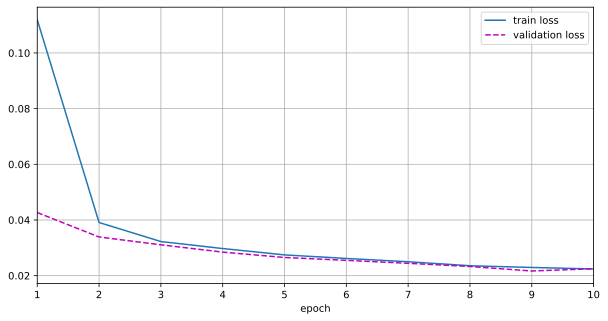

In [9]:
device = d2l.try_gpu()

model = UNet().to(device)
train(model, beta, num_epochs=10, lr=1e-4)

In [12]:
torch.save(model, "mnist_diffusion.pt")
loaded_model = torch.load("mnist_diffusion.pt")
loaded_model = loaded_model.to(device)

**(f) Has the training converged? Do you think we should train longer?<span style="float:right"> (1 point)</span>**

The network seems to be at least mostly converged, but training it a bit longer could show if it actually converged completely.

## 11.6 Sampling from the model (9 points)

Once the model is trained, we can sample from it using Algorithm 2 from paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf):

**Algorithm 2**:  
1: $\mathbf{x}_T \sim \mathcal{N}(\mathbf 0, \mathbf I)$  
2: for $t = T, \dots, 1$ do  
3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{z} \sim \mathcal{N}(\mathbf 0, \mathbf I)$ if $t > 1$, else $\mathbf{z} = \mathbf{0}$  
4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{x}_{t-1} = \frac{1}{\sqrt{a_t}} \left( \mathbf{x}_t - \frac{1-a_t}{\sqrt{1-\bar{a}_t}} \mathbf{\epsilon}_\theta \left(\mathbf{x}_t, t\right)\right) + \mathbf{\sigma}_t \mathbf{z}$  
5: end for  
6: return $\mathbf{x}_0$

**(a) In step 3 of algorithm 2, $\mathbf{z}$ is set to $\mathbf{0}$ some times. What is the effect of this?<span style="float:right"> (1 point)</span>**

z is only set to 0 at the very last step to avoid adding some random noise to the final image.

**(b) In step 4 of algorithm 2, $\mathbf{x}_{t-1}$ is computed based on three ingredients: $\mathbf{x}_t$, $\mathbf{\epsilon}_\theta \left(\mathbf{x}_t, t\right)$, and $\mathbf{z}$. What do these represent? <span style="float:right"> (2 points)</span>**

* $\mathbf{x}_t$: The noisy image of step t
* $\mathbf{\epsilon}_\theta \left(\mathbf{x}_t, t\right)$: The noise predicted by the network
* $\mathbf{z}$: Some random noise.

**(c) How does the sampling time depend on the number of diffusion steps $T$?<span style="float:right"> (1 point)</span>**

The sampling time does grow linearly with the number of diffusion steps, because they have to be performed sequentially.

**(d) Complete the code below to sample a minibatch from the model.<span style="float:right"> (2 points)</span>**

* Use the equations in Algorithm 2.
* Use $\sigma_t = \sqrt{\beta_t}$, as suggested in the paper.
* Keep in mind that Algorithm 2 uses $t=1$ as the first time step, whereas we use $t=0$.

*Expected output: after training, your model should generate fairly realistic, clean images when given random inputs.*

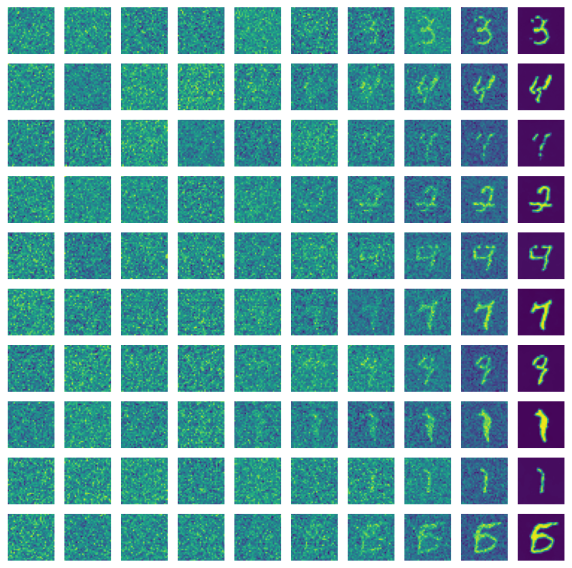

In [49]:
def sample_from_model(x, model: UNet, beta):
    # keep track of x at different time steps
    x_hist = []
    with torch.no_grad():
        # loop over all time steps in reverse order
        for i in reversed(range(0, beta.shape[0])):
            # copy the time step for each sample in the minibatch
            t = (torch.ones(x.shape[0]) * i).long().to(device)
            # TODO compute the next value of x
            z = torch.normal(0, 1, x.shape).to(device) if i > 0 else 0
            eps = model.forward(x, t)
            x = (1 / torch.sqrt(alpha[t].reshape(x.shape[0], 1, 1, 1))) * (
                    x - ((1 - alpha[t].reshape(x.shape[0], 1, 1, 1)) / torch.sqrt(
                1 - alpha_bar[t].reshape(x.shape[0], 1, 1, 1))) * eps) + (
                            torch.sqrt(beta[t]).reshape(x.shape[0], 1, 1, 1) * z)
            if i % 100 == 0:
                x_hist.append(x.detach().cpu().numpy())
    return x, x_hist


def plot_x_hist(x_hist):
    # plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(len(x_hist)):
        for j in range(10):
            plt.subplot(10, 10, j * 10 + i + 1)
            plt.imshow(x_hist[i][j, 0])
            plt.axis('off')


# TODO initialize x with the right values
# shape: [10, 1, 32, 32]
x = torch.normal(0, 1, x_0[:10].shape).to(device)

x, x_hist = sample_from_model(x, model, beta)
plot_x_hist(x_hist)

**(e) Explain the X and Y axes of this figure.<span style="float:right"> (1 point)</span>**

On the x-axis, we can see the evolution of the image generation over the different diffusion steps. The y-axis shows multiple example initializations.

**(f) In a variational autoencoder or a GAN, the output is determined by the latent representation. How does that work for this diffusion model?<span style="float:right"> (1 point)</span>**

In a GAN or VAE, we sample once from the latent representation, while for the diffusion model, we sample from the target dimension and add randomness in every step.

**(g) Look at the generated intermediate samples over time in question (d). Do we need all of the steps? Why/why not?<span style="float:right"> (1 point)</span>**

The first three to four images do not seem to contain anything but random noise, so we can skip them in generation and start from step 300 to 400.

## 11.7 Experiments (5 points)

### Fixed initialization

How does the end result depend on the initialization? We will generate multiple images from the same initial noise to find out.

**(a) Complete and run the code below.</span>**

*Expected output: the model should still produce recognizable shapes.*

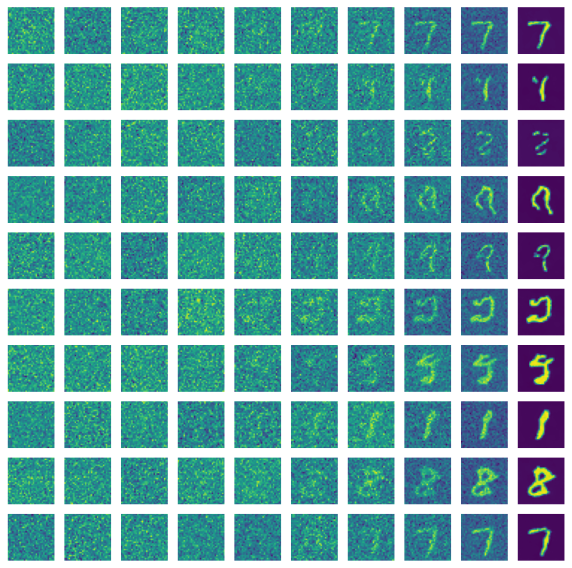

In [51]:
# TODO initialize x=x_T with the right values for one image
# (see earlier question)
# shape: [1, 1, 32, 32]
x = torch.normal(0, 1, x_0[:1].shape).to(device)  # TODO: change
# repeat this to generate 10 images from the same initialization
x = x.repeat(10, 1, 1, 1)

x, x_hist = sample_from_model(x, model, beta)
plot_x_hist(x_hist)

**(b) Does the model always produce the same output from the same initial input? Why, or why not?<span style="float:right"> (2 points)</span>**

No, it does produce different outputs as there is still randomness introduced during the sampling, namely z.

### No randomness between time steps

To check the influence of noise during sampling, we can remove the term $\sigma_t \mathbf{z}$ from Algorithm 2.

**(c) Create a new function `deterministic_sample_from_model`, based on `sample_from_model`, that does not include this term.<span style="float:right"> (2 points)</span>**

In [52]:
def deterministic_sample_from_model(x, model: UNet, beta):
    # keep track of x at different time steps
    x_hist = []
    with torch.no_grad():
        # loop over all time steps in reverse order
        for i in reversed(range(0, beta.shape[0])):
            # copy the time step for each sample in the minibatch
            t = (torch.ones(x.shape[0]) * i).long().to(device)
            # TODO compute the next value of x
            z = torch.normal(0, 1, x.shape).to(device) if i > 0 else 0
            eps = model.forward(x, t)
            x = (1 / torch.sqrt(alpha[t].reshape(x.shape[0], 1, 1, 1))) * (
                    x - ((1 - alpha[t].reshape(x.shape[0], 1, 1, 1)) / torch.sqrt(
                1 - alpha_bar[t].reshape(x.shape[0], 1, 1, 1))) * eps)
            if i % 100 == 0:
                x_hist.append(x.detach().cpu().numpy())
    return x, x_hist

**(d) Generate some samples using the new function.**

*Expected output: you should get a different result than before.*

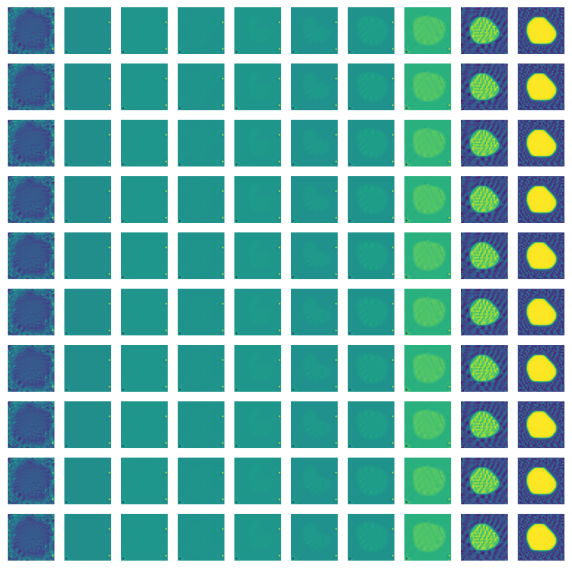

In [54]:
# TODO initialize x with the right values
# (see earlier questions)
# shape: [10, 1, 32, 32]
x = torch.normal(0, 1, x_0[:1].shape).to(device)
x = x.repeat(10, 1, 1, 1)

x, x_hist = deterministic_sample_from_model(x, model, beta)
plot_x_hist(x_hist)

**(e) What can you conclude from these results? Is the random noise during sampling important?<span style="float:right"> (1 point)</span>**

Yes, we cannot see any meaningful shapes anymore, which shows us that randomness between the time steps in crucial for the sampling to work.

## 11.8 Making the model conditional (6 points)

Similar to the conditional VAE in the previous assignment, we can make the diffusion model conditional by including class labels. This allows us to generate samples from a specific digit.

We will include the class information alongside the existing positional encoding, using a [`torch.nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) layer to map the 10 digits to a higher-dimensional space.

### Conditional model

**(a) Study the implemenation of UNetConditional to see how this works.**

In [ ]:
class UNetConditional(nn.Module):
    def __init__(self, c_in=1, c_out=1, n_classes=10, device="cuda"):
        super().__init__()
        self.device = device

        bilinear = True
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, c_out)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

        self.label_embedding = nn.Embedding(n_classes, 256)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
                10000
                ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def label_encoding(self, label, channels, embed_size):
        return self.label_embedding(label)[:, :channels, None, None].repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t, label):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16) + self.label_encoding(label, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8) + self.label_encoding(label, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4) + self.label_encoding(label, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8) + self.label_encoding(label, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16) + self.label_encoding(label, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32) + self.label_encoding(label, 64, 32)
        output = self.outc(x)
        return output

**(b) As in [the paper by Ho et al.](https://arxiv.org/pdf/2006.11239.pdf), the position and label encoding are added in every layer of the model, instead of as an input to the first layer only. Why do you think the authors made this choice?<span style="float:right"> (1 point)</span>**

TODO Your answer here.

### Conditional training loop

**(c) Create a new function `train_conditional` to train this model.<span style="float:right"> (1 point)</span>**

In [ ]:
def train_conditional(model, beta, num_epochs=10, lr=1e-3):


# TODO implement the training loop, based on your earlier train function

def test_conditional(model, test_iter, beta):

# TODO implement the testing loop, based on your earlier test function

**(d) Train the conditional model.**

*Expected output: in our implementation, the training loss started at around 0.1 and went down quickly to 0.03 and lower.*

In [ ]:
model_conditional = UNetConditional().to(device)
train_conditional(model_conditional, beta, num_epochs=10, lr=1e-4)

### Conditional sampling

**(e) Modify the sampling function to include a label.<span style="float:right"> (1 point)</span>**

In [ ]:
def sample_from_model_conditional(x, model, beta, label):

# TODO copy and modify sample_from_model to include the label

**(f) Sample a few digits with label `3`.<span style="float:right"> (1 point)</span>**

*Expected output: you should see recognizable images with the number you requested.*

In [ ]:
# TODO sample some digits

**(g) Complete the code to sample and plot 10 samples for every digit.<span style="float:right"> (1 point)</span>**

In [ ]:
x_per_class = []
for label in range(10):
    # sample 10 digits with this label
    x = torch.zeros_like(x_0[:10]).to(device)
    x_per_class.append(x.detach().cpu().numpy())

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, j * 10 + i + 1)
        plt.imshow(x_per_class[j][i, 0])
        plt.axis('off')

**(h) Compare the output of the conditional model with that of the unconditional model. Which one is better?<span style="float:right"> (1 point)</span>**

TODO Your answer here.

## 11.9 Discussion (6 points)

**(a) Compare the sources of randomness in our diffusion model with that in the variational autoencoder and the GAN in earlier assignments. What are the main differences?<span style="float:right"> (1 point)</span>**

TODO Your answer here.

**(b) Would you be able to train a good digit classification model on the initial input to the sampling function? Why, or why not?<span style="float:right"> (1 point)</span>**

Hint: for variational autoencoders and GANs, there is a clear link between the input (a latent feature vector) and the output of the decoder. How does this work for our diffusion model?

TODO Your answer here.

**(c) When loading the data, we normalized the image intensities to [-1, +1], instead of [0, 1] or [0, 255]. Why is this a good input range for this diffusion model?<span style="float:right"> (1 point)</span>**

TODO Your answer here.

**(d) In this assignment, we use a $\beta$ schedule that has a small $\beta=1e-4$ at the initial time steps ($t=0$), and a larger $\beta=0.02$ at the end ($t=T$). Why is it useful to choose an increasing $\beta$?<span style="float:right"> (1 point)</span>**

TODO Your answer here.

**(e) What would happen if we made $\beta$ very small?<span style="float:right"> (1 point)</span>**

TODO Your answer here.

**(f) What would happen if we made $\beta$ very large?<span style="float:right"> (1 point)</span>**

TODO Your answer here.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 42 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 55ce6f4 / 2023-11-30</span>